## Задача.

В некоторой комнании менеджер по подбору персонала разбирал полученные отклики на вакансию. Описание вакансии содержало одно небольшое задание для соискателей, которое проверяло внимательное прочтение ваканисии перед откликом и способности решить несложную логическую задачу и доступно изложить решение.

В процессе просмотра откликов менеджер вел небольшой Excel-файл, где фиксировал краткую информацию по каждому соискателю. В какой-то момент менеджеру по подбору персонала начало *казаться*, что есть связь между возрастом соискателей и наличием решения задачи в сопроводительном письме.

Перед тем как передать результаты скриннинга нанимающему менеджеру, менеджер по подбору персонала решил поделиться своими мыслями о связи возраста с наличием решения. Для этого он попросил аналитика данных построить график, который подтвердил бы его догадки.

Однако аналитик не стал доверять тому, что *показалось* менеджеру по подбору персонала и решил все перепроверить и самостоятельно сделать вывод. Как они договорились, аналитик вернулся ровно с одним графиком и коротким (длинной в 1 твит) комментарием к графику.

---

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [ ]:
data = pd.read_csv('data.csv')

print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   applicant_name   325 non-null    object 
 1   Age              281 non-null    float64
 2   Ответ на вопрос  325 non-null    object 
dtypes: float64(1), object(2)
memory usage: 7.7+ KB
None


,Age
count,281.000000
mean,26.800712
std,11.999232
min,15.000000
25%,21.000000
50%,24.000000
75%,31.000000
max,186.000000


В age явно есть ошибки при заполнении анкеты, выбросы. Удалим их из датасета, воспользовавшись межквартальным размахом

In [ ]:
q1 = data['Age'].quantile(0.25)
q3 = data['Age'].quantile(0.75)
iqr = q3 - q1
data_without_outliers = data[(data['Age'] < q3 + 1.5 * iqr) & (data['Age'] > q1 - 1.5 * iqr)]

data_without_outliers.describe()

,Age
count,274.000000
mean,25.697080
std,6.336665
min,15.000000
25%,21.000000
50%,24.000000
75%,30.000000
max,43.000000


Посмотрим на распределение по всем ответам

<ipython-input-6-bac334a01c7d>:1: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#c296f7'` for the same effect.

  sns.boxplot(x='Ответ на вопрос', y='Age', data=data_without_outliers, color='#c296f7',


([0, 1, 2, 3],
 [Text(0, 0, 'да'),
  Text(1, 0, 'нет'),
  Text(2, 0, 'неверное решение'),
  Text(3, 0, 'да, но очень плохо описано')])

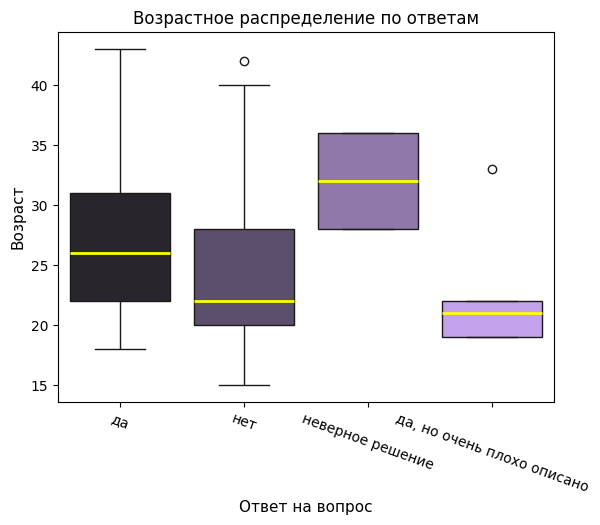

In [ ]:
sns.boxplot(x='Ответ на вопрос', y='Age', data=data_without_outliers, color='#c296f7',
            hue='Ответ на вопрос', medianprops={'color': 'yellow', 'linewidth': 2})
plt.title("Возрастное распределение по ответам", fontsize=12)
plt.xlabel("Ответ на вопрос", fontsize=11)
plt.ylabel("Возраст", fontsize=11)
plt.xticks(rotation=-20)

Посмотрим на распределение по целевым ответам

<ipython-input-22-66040bb64969>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ответ на вопрос', y='Age', data = working_data,


Text(0, 0.5, 'Возраст')

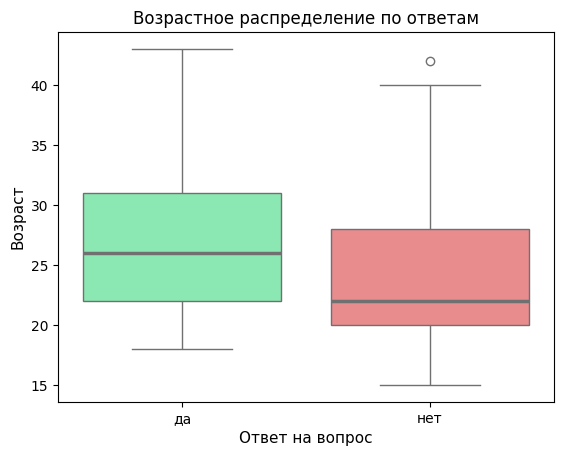

In [ ]:
working_data = data_without_outliers[(data_without_outliers['Ответ на вопрос'] == 'нет') | (data_without_outliers['Ответ на вопрос'] == 'да')]

sns.boxplot(x='Ответ на вопрос', y='Age', data = working_data,
            palette=['#7df7b1', '#f77d7f'], medianprops={'linewidth': 2.5})
plt.title("Возрастное распределение по ответам", fontsize=12)
plt.xlabel("Ответ на вопрос", fontsize=11)
plt.ylabel("Возраст", fontsize=11)

In [ ]:
final_table = {
    'Ответ на вопрос': working_data['Ответ на вопрос'].unique(),
    'Количество соискателей': working_data.groupby('Ответ на вопрос').agg({'applicant_name' : 'count'}).reset_index()['applicant_name'].values,
    'Средний возраст': working_data.groupby('Ответ на вопрос').agg({'Age' : 'mean'}).reset_index()['Age'].values.round(1),
    'Медианный возраст': working_data.groupby('Ответ на вопрос').agg({'Age' : 'median'}).reset_index()['Age'].values
}
pd.DataFrame(final_table)

,Ответ на вопрос,Количество соискателей,Средний возраст,Медианный возраст
0,да,120,27.4,26.0
1,нет,145,24.2,22.0


Проведем Т-тест Стьюдента, чтобы выяснить, насколько различия в выборках случайны

In [ ]:
yes_data = working_data[working_data['Ответ на вопрос'] == 'да']
no_data = working_data[working_data['Ответ на вопрос'] == 'нет']
ttest_results = stats.ttest_ind(a = yes_data['Age'], b = no_data['Age'], equal_var=True)

print('t-statistic:', round(ttest_results.statistic, 5))
print('p-value:', round(ttest_results.pvalue, 5))

t-statistic: 4.27408
p-value: 3e-05


**ВЫВОД**

В среднем, решение задачи в сопроводительном письме чаще прикрепляют люди постарше, их средний возраст - 27. Средний возраст тех, кто не прикрепляет решение - 24. Различие между группами статистически значимо